## 数据处理专题：去极值、标准化、中性化<br>
**导语**：一般的数据预处理中常提及到三类处理：去极值、标准化、中性化。我们将向大家讲述这常见的三种数据处理操作。

#### 一、去极值
　　在分析上市公司当季净利润同比增长率数据时，我们往往会被其中一些公司的数据干扰，如图中江西长运，2017三季度净利润同比增长率高达32836.04%！而实际上大部分公司的当季净利润同比增长率的数值都远远达到这个值的百分之一。那么数据去极值操作就显得尤为关键，可以剔除掉数据干扰项，提高数据结论的准确性。
  ![](http://u.thsi.cn/fileupload/data/Sns/2018/11ec5551b3421dff2c6a65e39ab723d8.png)
  
　　一般去极值的处理方法就是确定该项指标的上下限，然后超过或者低于限值的数据统统即为限值。其中上下限数值判断标准有三种，分别为 MAD、 3σ、百分位法。
  
　　以沪深300成分股的pe值为原始数据，向大家阐述MAD、 3σ、百分位法。


In [69]:
import datetime as dt
# 训练样本开始时间
start = '20100101' 
# 训练样本结束时间
end = '20180411'
trade_days = get_trade_days(start, end).strftime('%Y-%m-%d')
trade_days

array(['2010-01-04', '2010-01-05', '2010-01-06', ..., '2018-04-09',
       '2018-04-10', '2018-04-11'], 
      dtype='<U10')

In [1]:
import numpy as np
import pandas as pd
import math
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt 

date='20180125'
stock=get_index_stocks('000300.SH',date)
q = query(
    valuation.symbol,
    valuation.pe_ttm,
    valuation.current_market_cap
).filter(valuation.symbol.in_(stock))
data = get_fundamentals(q,date=date)
data.columns = [['symbol','pe_ratio','market_cap']]
data = data.set_index(data.symbol.values)
del data['symbol']
data['1/PE'] = 1/data['pe_ratio']
data.head()

,pe_ratio,market_cap,1/PE
000001.SZ,10.59,2.402355e+11,0.094429
000002.SZ,18.61,3.903084e+11,0.053735
000008.SZ,54.53,1.661121e+10,0.018339
000060.SZ,27.51,2.613508e+10,0.036350
000063.SZ,-115.27,1.237605e+11,-0.008675


     将1/PE的数据分布，运用绘图函数展示出来：

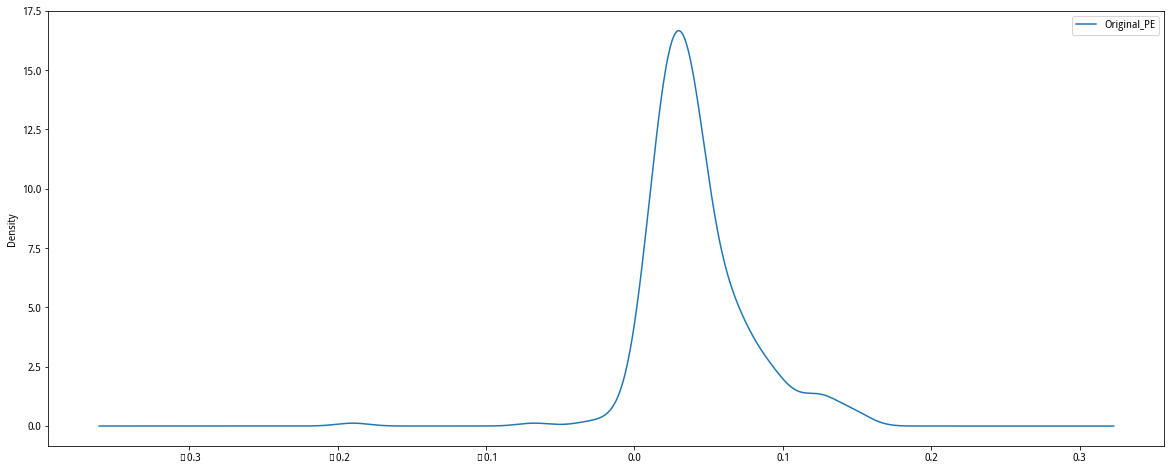

In [2]:
fig = plt.figure(figsize = (20, 8))
ax = data['1/PE'].plot.kde(label = 'Original_PE')
ax.legend()

1.MAD法：<br>

　　MAD又称为绝对值差中位数法，是一种先需计算所有因子与平均值之间的距离总和来检测离群值的方法，处理的逻辑：<br>

　　　第一步，找出所有因子的中位数 Xmedian<br>
　　　第二步：得到每个因子与中位数的绝对偏差值 Xi−Xmedian<br>
　　　第三步：得到绝对偏差值的中位数 MAD<br>
　　　第四步：确定参数 n，从而确定合理的范围为 [Xmedian−nMAD,Xmedian nMAD]，并针对超出合理范围的因子值做如下的调整：<br>
   ![](http://u.thsi.cn/fileupload/data/Sns/2018/2eafff69f4ab952e315995983535e411.png)
　　　MAD法代码实现：<br>

In [4]:
def filter_extreme_MAD(series,n): #MAD:中位数去极值
  median = series.quantile(0.5)
  new_median = ((series - median).abs()).quantile(0.50)
  max_range = median + n*new_median
  min_range = median - n*new_median
  return np.clip(series,min_range,max_range)

　　对原始数据进行MAD处理后的结果：

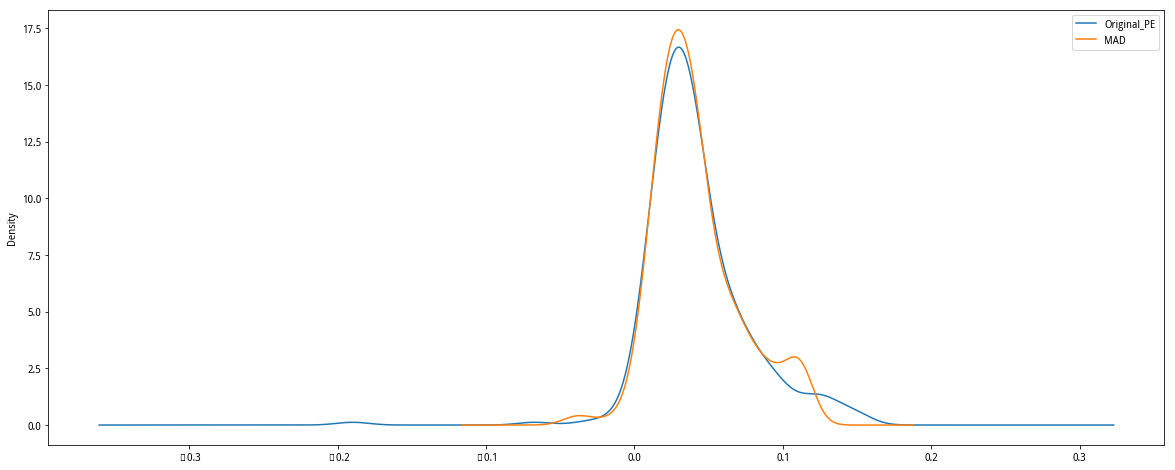

In [5]:
fig = plt.figure(figsize = (20, 8))
ax = data['1/PE'].plot.kde(label = 'Original_PE')
ax = filter_extreme_MAD(data['1/PE'],5).plot.kde(label = 'MAD')
ax.legend()

2.3σ法

　　3σ法又称为标准差法。标准差本身可以体现因子的离散程度，是基于因子的平均值 Xmean而定的。在离群值处理过程中，可通过用 Xmean±nσ来衡量因子与平均值的距离。

　　标准差法处理的逻辑与MAD法类似:<br>
　　　第一步：计算出因子的平均值与标准差<br>
　　　第二步：确认参数 n（这里选定 n = 3）<br>
　　　第三步：确认因子值的合理范围为 [Xmean−nσ,Xmean nσ]，并对因子值作如下的调整：<br>
   ![](http://u.thsi.cn/fileupload/data/Sns/2018/8eb3a0176d63d06e5a09f1f55d669c44.png)

　　3σ代码实现：

In [6]:
def filter_extreme_3sigma(series,n=3): #3 sigma
  mean = series.mean()
  std = series.std()
  max_range = mean + n*std
  min_range = mean - n*std
  return np.clip(series,min_range,max_range)

    对原始数据进行3σ处理后的结果：

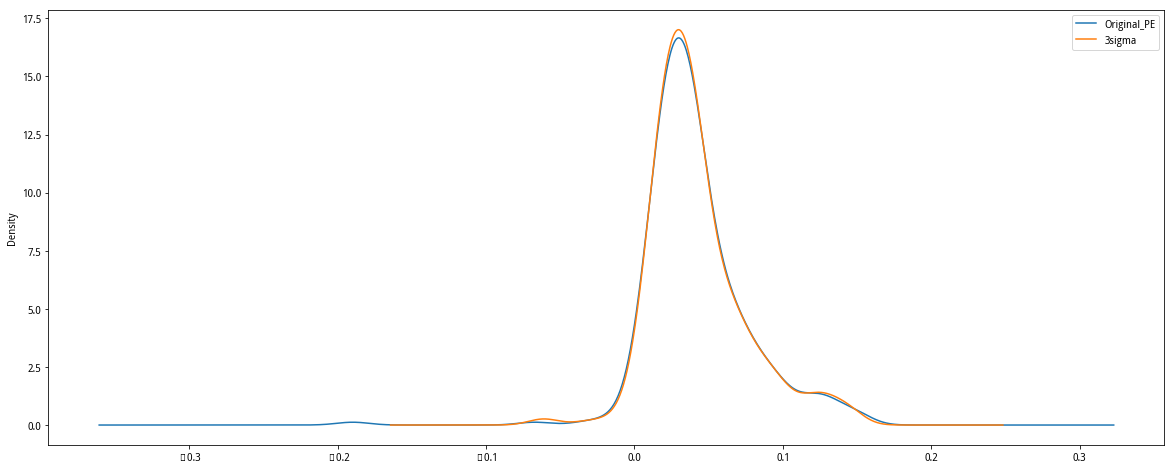

In [7]:
fig = plt.figure(figsize = (20, 8))
ax = data['1/PE'].plot.kde(label = 'Original_PE')
ax = filter_extreme_3sigma(data['1/PE']).plot.kde(label = '3sigma')
ax.legend()

3.百分位法：

　　将因子值进行升序的排序，对排位百分位高于97.5%或排位百分位低于2.5%的因子值，进行类似于 MAD 、 3σ 的方法进行调整。
  
　　百分位法代码实现：

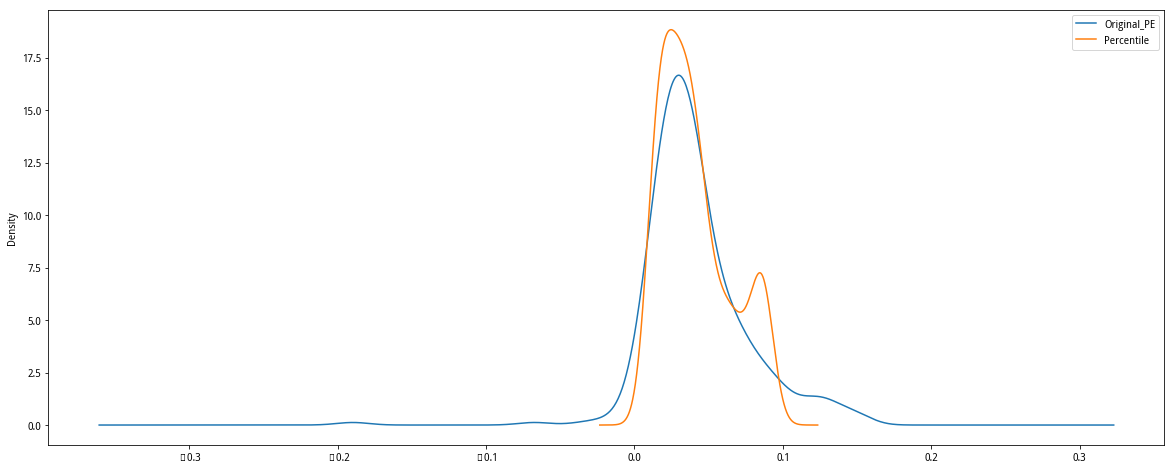

In [8]:
def filter_extreme_percentile(series,min = 0.10,max = 0.90): #百分位法
  series = series.sort_values()
  q = series.quantile([min,max])
  return np.clip(series,q.iloc[0],q.iloc[1])

fig = plt.figure(figsize = (20, 8))
ax = data['1/PE'].plot.kde(label = 'Original_PE')
ax = filter_extreme_percentile(data['1/PE']).plot.kde(label = 'Percentile')
ax.legend()

二、标准化

　　继续深入的做股票数据分析，假设我们需买入当季净利润同比增长率较高和股息率较高的股票，如果单纯的将两个指标相加，然后取最终值较大的那些股票，那么会面临一个非常严重的问题：两个指标的数值意义不同。上市公司达到股息率10%难于净利润同比增长率10%，一般股息率都小于5%，而净利润增长率则远远超过5%的数值，因此简单的相加，然后选股会淡化股息率指标。  
  
　　那么这种情况下，数据标准化处理可以解决问题。

　　标准化在统计学中有一系列含义，一般使用z-score的方法。处理后的数据从有量纲转化为无量纲，使得不同的指标能够进行比较和回归。

　z-score的方法介绍

　　标准化后的数值 = (原始值-单个指标内所有值的均值)/单个指标内所有值的标准差

　z-score的方法代码实现：

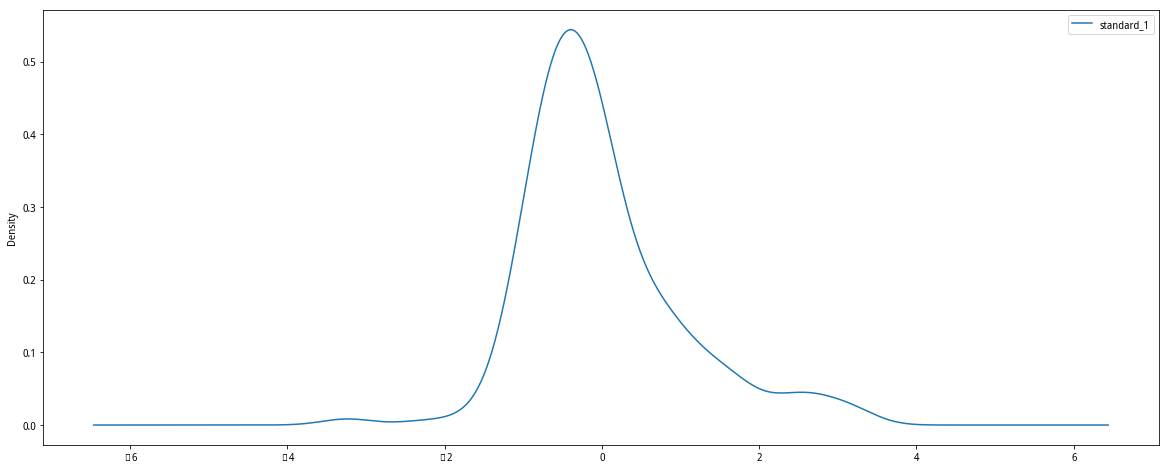

In [9]:
def standardize_series(series): #原始值法
  std = series.std()
  mean = series.mean()
  return (series-mean)/std
fig = plt.figure(figsize = (20, 8))
new = filter_extreme_3sigma(data['1/PE'])
ax = standardize_series(new).plot.kde(label = 'standard_1')
ax.legend()

In [10]:
standard_2 = standardize_series(new.rank())
standard_2.head()

000001.SZ    1.458269
000002.SZ    0.847295
000008.SZ   -1.135490
000060.SZ    0.028820
000063.SZ   -1.677298
Name: 1/PE, dtype: float64

三、中性化

　　继续深入的做股票数据分析，你可能会发现银行股的市盈率特别的低，而互联网行业的市盈率就特别的高，如果直接用市盈率指标，无论你做了标准化还是去极值，你只会挑选出银行股，而不可能挑选出互联网股，那么互联网中市盈率最低的股票和银行股中市盈率最高的股票，应该如何体现它们的真实意义呢？
    
　　这种情况下你就需要进行数据中性化处理。

　　**中性化处理概念**：为了在用某一因子时能剔除其他因素的影响，使得选出的股票更加分散。标准化用于多个不同量级指标之间需要互相比较或者数据需要变得集中，而中性化的目的在于消除因子中的偏差和不需要的影响。

　　**具体方法**：根据大部分的研报对于中性化的处理，主要的方法是利用回归得到一个与风险因子线性无关的因子，即通过建立线性回归，提取残差作为中性化后的新因子。这样处理后的中性化因子与风险因子之间的相关性严格为零。
![](http://u.thsi.cn/fileupload/data/Sns/2018/e56d5d0515fb1acb268d47eac54ef56b.png)
　　用python实现中性化：对原始数据进行3σ处理后的结果，进行中性化处理。

　　数据获取

In [11]:
import numpy as np
import pandas as pd
import math
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt 

date='20180125'
stock=get_index_stocks('000300.SH',date)
q = query(
    valuation.symbol,
    valuation.pe_ttm,
    valuation.current_market_cap
).filter(valuation.symbol.in_(stock))
data = get_fundamentals(q,date=date)
data.columns = [['symbol','pe_ratio','market_cap']]
data = data.set_index(data.symbol.values)
del data['symbol']
data['1/PE'] = 1/data['pe_ratio']
data.head()

,pe_ratio,market_cap,1/PE
000001.SZ,10.59,2.402355e+11,0.094429
000002.SZ,18.61,3.903084e+11,0.053735
000008.SZ,54.53,1.661121e+10,0.018339
000060.SZ,27.51,2.613508e+10,0.036350
000063.SZ,-115.27,1.237605e+11,-0.008675


In [3]:
get_trade_days('20050101', '20221231').strftime('%Y-%m-%d').shape

(3402,)

3σ处理处理函数

In [13]:
def filter_extreme_3sigma(series,n=3): #3 sigma
  mean = series.mean()
  std = series.std()
  max_range = mean + n*std
  min_range = mean - n*std
  return np.clip(series,min_range,max_range)

行业代码列表

In [14]:
SHENWAN_INDUSTRY_MAP = {
        'S11' :'农林牧渔',
        'S21' :'采掘',
        'S22' :'化工',
        'S23' :'钢铁',
        'S24' :'有色金属',
        'S27' :'电子',
        'S28' :'汽车',
        'S33' :'家用电器',
        'S34' :'食品饮料',
        'S35' :'纺织服装',
        'S36' :'轻工制造',
        'S37' :'医药生物',
        'S41' :'公用事业',
        'S42' :'交通运输',
        'S43' :'房地产',
        'S45' :'商业贸易',
        'S46' :'休闲服务',
        'S48' :'银行',
        'S49' :'非银金融',
        'S51' :'综合',
        'S61' :'建筑材料',
        'S62' :'建筑装饰',
        'S63' :'电气设备',
        'S64' :'机械设备',
        'S65' :'国防军工',
        'S71' :'计算机',
        'S72' :'传媒',
        'S73' :'通信'
        }

行业代码标记

In [15]:
def get_industry_exposure(order_book_ids):
    df = pd.DataFrame(index=SHENWAN_INDUSTRY_MAP.keys(), columns=order_book_ids)
    for stk in order_book_ids:
        try:
            df[stk][get_symbol_industry(stk).s_industryid1] = 1
        except:
            continue
    return df.fillna(0)#将NaN赋为0

中性化函数

In [16]:
# 需要传入单个因子值和总市值
def neutralization(factor,mkt_cap = False, industry = True):
  y = factor
  if type(mkt_cap) == pd.Series:
    LnMktCap = mkt_cap.apply(lambda x:math.log(x))
    if industry: #行业、市值
      dummy_industry = get_industry_exposure(factor.index)
      x = pd.concat([LnMktCap,dummy_industry.T],axis = 1)
    else: #仅市值
      x = LnMktCap
  elif industry: #仅行业
    dummy_industry = get_industry_exposure(factor.index)
    x = dummy_industry.T
  result = sm.OLS(y.astype(float),x.astype(float)).fit()
  return result.resid

函数调用

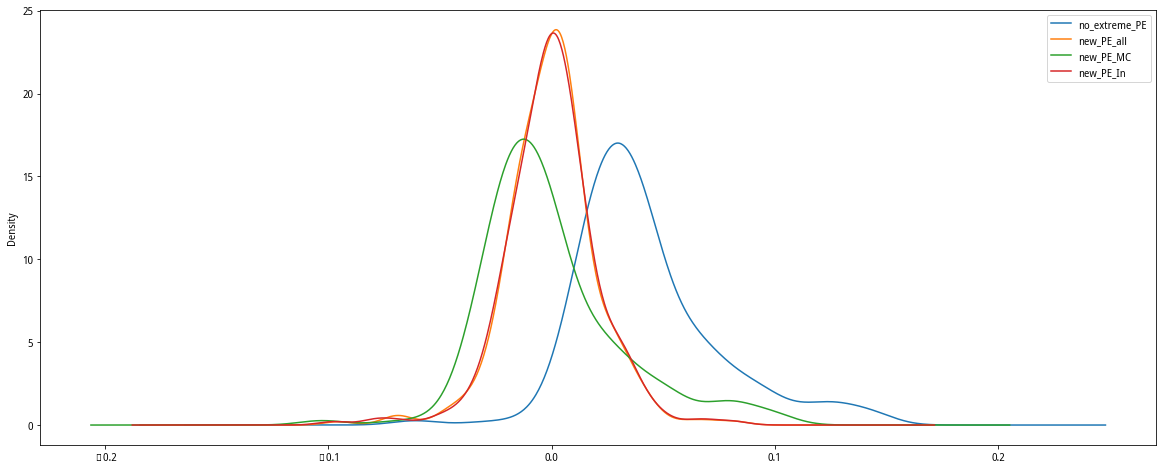

In [17]:
#使用3sigma离群值处理法
no_extreme_PE = filter_extreme_3sigma(data['1/PE'])
#行业市值中性
new_PE_all = neutralization(no_extreme_PE,data['market_cap'])
#市值中性
new_PE_MC = neutralization(no_extreme_PE,data['market_cap'],industry = False)
#行业中性
new_PE_In = neutralization(no_extreme_PE) 

fig = plt.figure(figsize = (20, 8))
ax = no_extreme_PE.plot.kde(label = 'no_extreme_PE')
ax = new_PE_all.plot.kde(label = 'new_PE_all')
ax = new_PE_MC.plot.kde(label = 'new_PE_MC')
ax = new_PE_In.plot.kde(label = 'new_PE_In')
ax.legend()

　　结果输出:能够看出市值和行业中性化后的PE分布变得更加均匀，其中行业中性化比市值中性化的效果更好。